on fais aussi apprendre la variance et la moyenne de cette amnièere on apprende des solution pour une famille de conditions initiales. 

# PINNs Advection Equation

This notebook solves the advection-diffusion equation using a physics-informed neural network (PINN). The equation is given by:

\begin{cases}
\partial_t u + a \partial_x u = 0 \\
u(t=0, x) = u_0(x, \mu)
\end{cases}

where $u$ is the dependent variable, $t$ is time, $x$ is space, and $a$ is the diffusion coefficient (velocity) The initial condition is given by:

\begin{equation}
u_0(x) = \exp(-(x-0.5)^2/0.1^2)
\end{equation}

The exact solution is given by:
`
\begin{equation}
u(x,t) = u_0(x-a*t)
\end{equation}

## Analysis:

### Neural Network
A neural network is a function that maps an input $X$ to an output $Y$ by performing successive linear and nonlinear transformations. The linear transformations are represented by a set of weights $W$ and biases $b$ and the nonlinear transformations are represented by activation functions $\sigma$. The output of a neural network is given by:

$$\overline{u_\theta}(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

We will train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset. 

### Physics Informed Neural Network = NN + PDE

We can use a neural network to approximate any function (Universal Approximation Theorem). In our case, we want to approximate the solution of a PDE. We can do this by minimizing the error of the PDE in a certain number of points inside our domain.

$$\overline{u_\theta}\approx u(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial \overline{u_\theta}}{\partial t},\frac{\partial \overline{u_\theta}}{\partial x}$.

We assume then: $$\overline{u_\theta}(x,t)\approx u(x,t,\theta)$$ 

Then:

$$\left(\frac{\partial\overline{u_\theta}}{\partial t} + a \frac{\partial \overline{u_\theta}}{\partial x}\right) \approx \left(\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x}\right) =0$$

And:

$$\left(\frac{\partial\overline{u_\theta}}{\partial t} + a\frac{\partial \overline{u_\theta} }{\partial x}\right) \approx 0$$

We should also define the boundary conditions both in space and time as it follows:

boundary conditions in space:

$$bc_{space}(x)=x*(x-1)$$

boundary conditions in time:
$$bc_{time}(t)=t$$

Now we can define this function as $u_\theta$:

$${u_\theta}(x,t)= u_{0}(x)+ bc_{time}(t) * bc_{space}(x) * \overline{u_\theta}(x,t)$$ 

If $u_\theta \rightarrow 0$ then our $\overline{u_\theta}$ would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_{coll}$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $u_\theta$:

$$MSE_{u_\theta}=\frac{1}{N_{coll}}\sum^{N_{coll}}_{i=1}|u_\theta(t_{coll}^i,x_{coll}^i)|^2$$

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u_{exact}}=\frac{1}{N_{u_{exact}}}\sum^{N_{u_{exact}}}_{i=1}|y(t_{u_{exact}}^i,x_{u_{exact}}^i)-\overline{u_\theta}(t_{u_{exact}}^i,x_{u_{exact}}^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u_{exact}}+MSE_{u_\theta}$$

We are looking to minimize:
$$
\Theta* = argmin_\Theta \left\{ \frac{1}{N_{coll}}\sum^{N_{coll}}_{i=1}|u_\theta(t_{coll}^i,x_{coll}^i)|^2 + \frac{1}{N_{u_{exact}}}\sum^{N_{u_{exact}}}_{i=1}|y(t_{u_{exact}}^i,x_{u_{exact}}^i)-\overline{u_\theta}(t_{u_{exact}}^i,x_{u_{exact}}^i)|^2 \right\}
$$

where $u_\theta$ is the PDE and $u$ is the exact solution.

In [16]:
import os


import torch
import torch.nn as nn #is a PyTorch module that enables parallel processing of a neural network model across multiple GPUs
from torch.autograd import Variable

try:
    import torchinfo
    no_torchinfo = False
except ModuleNotFoundError:
    no_torchinfo = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")
import matplotlib.pyplot as plt
import numpy as np

torch loaded; device is cpu


## Neural Network 

In [17]:
class Net(nn.DataParallel): 
    
    """Defines the neural network model"""
    def __init__(self):
        
        super(Net, self).__init__(nn.Module)
        self.hidden_layer1 = nn.Linear(4, 30).double() 
        self.hidden_layer2 = nn.Linear(30, 30).double()
        self.hidden_layer3 = nn.Linear(30, 30).double()
        self.hidden_layer4 = nn.Linear(30, 10).double()
        self.output_layer = nn.Linear(10, 1).double()

    """Defines the sequence of operations that are applied to the input tensors to produce the output of the neural network"""
    def forward(self, x, t, mean, variance):
    
        inputs = torch.cat([x,t,mean,variance], axis=1)
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)
        return output


def network_BC(t): #t to define u_theta
    return t 


def network_BC_space(x): #t to define u_theta
    return x*(1-x)

### Parameters

In [18]:
class Parameters:
   def __init__(self, tf, file_name):
        self.xmin = 0.
        self.xmax = 1.
        self.tmin = 0.
        self.tmax = tf
        self.a = 1.
        self.learning_rate = 1e-2
        self.file_name = file_name
        self.min_mean = 0.5
        self.max_mean = 1.5
        self.min_variance = 0.4
        self.max_variance = 0.6
     
   def u0(self,x,mean,variance):
        return torch.exp(-(x - mean)**2 / (2 * variance))

## PINN

In [19]:
class Network:

    def __init__(self,param: Parameters):
        """Initializes the neural network model"""
        self.parameters = param 
        self.x_min, self.x_max = param.xmin, param.xmax
        self.t_min, self.t_max = param.tmin, param.tmax
        self.learning_rate = param.learning_rate
        self.u0 = param.u0
        self.tf = param.tmax
        self.a = param.a
        self.file_name = param.file_name
        self.min_mean, self.max_mean = param.min_mean, param.max_mean
        self.min_variance, self.max_variance = param.min_variance, param.max_variance
   
        script_dir = os.getcwd()
        self.file_name = os.path.join(script_dir, self.file_name)

        self.create_network() #returns the current working directory
        self.load(self.file_name)

    def __call__(self, *args):
        return self.net(*args)

    def create_network(self):
        """Creates the neural network model"""
        self.net = nn.DataParallel(Net()).to(device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate) #optimization algorithm
   
    def load(self, file_name):
        self.loss_history = []
        try:

            try:
                checkpoint = checkpoint = torch.load(file_name, map_location=torch.device('cpu'))
                
            except RuntimeError:
                checkpoint = torch.load(file_name, map_location=torch.device('cpu'))

            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.loss = checkpoint['loss']

            try:
                self.loss_history = checkpoint['loss_history']
            except KeyError:
                pass

            self.to_be_trained = False
            print("network loaded successfully")
    
        except FileNotFoundError:

            self.to_be_trained = True
            print("network was not loaded from file: training needed")
    
    @staticmethod
    def save(file_name, epoch, net_state, optimizer_state, loss, loss_history):
        torch.save({
            epoch: epoch,
            'model_state_dict': net_state,
            'optimizer_state_dict': optimizer_state,
            'loss': loss,
            'loss_history': loss_history,
        }, file_name)

    def pde(self, x, t, mean, variance):

        u = self.u0(x, mean, variance) + network_BC(t) * self(x, t, mean, variance)
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # it enables the creation of a computational graph for the gradients. A computational graph is a data structure that represents the operations performed on tensors and their dependencies, which allows for automatic differentiation and backpropagation.
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0] #(automatic)
        
        return u_t + self.a * u_x

    
    """This method predicts the value of u based on the given input variables x, t and u0"""

    def predict_u_from_torch(self, x, t, mean, variance): # x tensor pour lequel on calcule la solution, t float, u0 float qu'on converti en tensor 
        ones = torch.ones(x.shape, dtype=torch.double, device=device)
        pt_mean = mean * ones
        pt_variance = variance * ones
        pt_t = t * ones
        pred = self.u0(x, pt_mean, pt_variance) + network_BC(pt_t) * self(x, pt_t, pt_mean, pt_variance)

        return pred

    #Pour l'instant c'est pas utilisé
    """This method predicts the value of u for a given input x and a mesh object"""
    def predict_u(self, x, t, mesh): # x float t float mesh object

        #We need to reshape the input x to be a column vector
        reshaped_x = x.reshape((x.size, 1))
        pt_x = Variable(torch.from_numpy(reshaped_x).double(), requires_grad=True).to(device)
        reshaped_t = t.reshape((x.size, 1))
        pt_t = Variable(torch.from_numpy(reshaped_t).double(), requires_grad=False).to(device)

        u_pred = self.u0(pt_x) + network_BC(pt_t) * self(pt_x, pt_t) * network_BC_space(pt_x)

        return u_pred.detach().cpu().numpy().reshape(x.shape)
    
    @staticmethod
    def random(min_value, max_value, shape, requires_grad=False, device=device):
        random_numbers = torch.rand(shape, device=device, dtype=torch.double, requires_grad=requires_grad)
        return min_value + (max_value - min_value) * random_numbers
    
    """This method generates the data for the training process"""
    def make_data(self, n_data):
        
        shape = (n_data, 1)
        """We generate for each variable a random number between the min and max value"""
        self.x_data = Network.random(self.x_min, self.x_max, shape)
        self.t_data = Network.random(self.t_min, self.t_max, shape)
        self.mean_data = Network.random(self.min_mean, self.max_mean, shape)
        self.variance_data = Network.random(self.min_variance, self.max_variance, shape)
        
        self.u_data_exact = Network.u_exact(self.x_data, self.t_data, self.a ,self.x_max, self.u0, self.mean_data, self.variance_data) # la solution exacte evaluée dans (xi,ti)
        self.zeros1 = torch.zeros(shape, dtype=torch.double, device=device) 
        
    """This method generates the collocation points for the training process to enforce 
       the partial differential equation (PDE) constraints during training."""
    
    def make_collocation(self, n_collocation):

        shape = (n_collocation, 1)
        #These variables will be used to evaluate the PDE at the collocation points.
        #collocation points are additional points where the PDE will be evaluated to ensure that the neural network solution satisfies the PDE
        self.x_collocation = Network.random(self.x_min, self.x_max, shape, requires_grad=True)
        self.t_collocation = Network.random(self.t_min, self.t_max, shape, requires_grad=True)
        self.mean_collocation = Network.random(self.min_mean, self.max_mean, shape, requires_grad=True)
        self.variance_collocation = Network.random(self.min_variance, self.max_variance, shape, requires_grad=True)

        self.zeros = torch.zeros(shape, dtype=torch.double, device=device) #This will be used as a target for the PDE constraints.

    """This method trains the neural network using a combination of PDE constraints and data fitting."""
    def train(self, epochs, n_collocation, n_data):

        mse_cost_function = torch.nn.MSELoss()

        try:
            best_loss_value = self.loss.item()
        except AttributeError:
            best_loss_value = 1e10

        for epoch in range(epochs):

            self.optimizer.zero_grad()

            self.loss = 0


            if n_collocation > 0:
                # Loss based on PDE constraints
        
                self.make_collocation(n_collocation)
                f_out = self.pde(self.x_collocation, self.t_collocation, self.mean_collocation, self.variance_collocation)
                mse_f = mse_cost_function(f_out, self.zeros)
                self.loss += mse_f
            

            if n_data > 0:
                # Loss based on data fitting (on apprend que avec des donées)
                self.make_data(n_data)
                u_pred = self.predict_u_from_torch(self.x_data, self.t_data, self.mean_data, self.variance_data) #reseau evaluée dans (xi,ti)
                #on essaie de minimizer la différence entre la solution exacte et la solution du réseau calculées en (xi,ti)
                mse_data = mse_cost_function(u_pred, self.u_data_exact) 
                
                self.loss += mse_data

            """Losses based on a combination of PDE constraints in the interior and boundary conditions""" 

            """data points"""
            xmin_tensor = torch.full(self.x_data.size(), self.x_min, dtype=torch.double, device=device, requires_grad=True)
            xmax_tensor = torch.full(self.x_data.size(), self.x_max, dtype=torch.double, device=device, requires_grad=True)
            tmin_tensor = torch.full(self.t_data.size(), self.t_min, dtype=torch.double, device=device, requires_grad=True)
            tmax_tensor = torch.full(self.t_data.size(), self.t_max, dtype=torch.double, device=device, requires_grad=True)
            min_mean_tensor = torch.full(self.mean_data.size(), self.min_mean, dtype=torch.double, device=device, requires_grad=True)
            max_mean_tensor = torch.full(self.mean_data.size(), self.max_mean, dtype=torch.double, device=device, requires_grad=True)
            min_variance_tensor = torch.full(self.variance_data.size(), self.min_variance, dtype=torch.double, device=device, requires_grad=True)
            max_variance_tensor = torch.full(self.variance_data.size(), self.max_variance, dtype=torch.double, device=device, requires_grad=True)
                
            #boundary (periodicity) en x
            f_boundary1 = self.predict_u_from_torch(xmin_tensor, self.t_data, self.mean_data, self.variance_data)
            f_boundary2 = self.predict_u_from_torch(xmax_tensor, self.t_data, self.mean_data, self.variance_data)
            f_boundaryx= torch.abs(f_boundary1 - f_boundary2)
            mse_f_boundaryx = mse_cost_function(f_boundaryx, self.zeros1)

            #boundary (periodicity) en t
            f_boundary3 = self.predict_u_from_torch(self.x_data, tmin_tensor, self.mean_data, self.variance_data)
            f_boundary4 = self.predict_u_from_torch(self.x_data, tmax_tensor, self.mean_data, self.variance_data)
            f_boundaryt= torch.abs(f_boundary3 - f_boundary4)
            mse_f_boundaryt = mse_cost_function(f_boundaryt, self.zeros1)

            #initial condition
            f_initial = self.predict_u_from_torch(self.x_data, self.t_min, self.mean_data, self.variance_data)
            f_initial_real= self.u0(self.x_data, self.mean_data, self.variance_data)
            f_initiale = torch.abs(f_initial - f_initial_real)
            mse_f_initial = mse_cost_function(f_initiale, self.zeros1)

            self.loss += mse_f_initial + mse_f_boundaryx + mse_f_boundaryt  

            #on fait la backpropagation et on met à jour les poids
            self.loss.backward() # This is for computing gradients using backward propagation
            self.optimizer.step() #This is equivalent to the update step in the gradient descent algorithm
          

            self.loss_history.append(self.loss.item())

            if epoch % 500 == 0:
                print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")
                try:
                    self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
                except NameError:
                    pass

            if self.loss.item() < best_loss_value:
                print(f"epoch {epoch: 5d}: best loss = {self.loss.item():5.2e}")
                best_loss = self.loss.clone()
                best_loss_value = best_loss.item()
                best_net = self.net.state_dict().copy()
                best_optimizer = self.optimizer.state_dict().copy()

        print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")

        try:
            self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
            self.load(self.file_name)

        except UnboundLocalError:
            pass
    
    @staticmethod
    def u_exact(x, t, a, xmax, u0, mean, variance, device=device):
        return u0((x-a*t) % xmax, mean, variance)
    
    
    def plot(self, t):

            _, ax = plt.subplots(1, 3, figsize=(15, 5))

            ax[0].semilogy(self.loss_history)
            ax[0].set_title("loss history")
      
            n_visu = 10000

            x = torch.linspace(0, 1, n_visu, dtype=torch.double, device=device)[:, None]

    
            u_pred = self.predict_u_from_torch(x, t, self.mean, self.variance)
            u_exact = Network.u_exact(x, t, self.a, self.x_max, self.u0, self.mean, self.variance)

            ax[1].plot(x.cpu(), u_exact.detach().cpu(), label="Exact solution")
            ax[1].plot(x.cpu(), u_pred.detach().cpu(), label="Prediction (NN)")
            ax[1].set_title("Prediction")
            ax[1].legend()

            error = torch.abs(u_pred - u_exact).detach().cpu()

            ax[2].plot(x.cpu(), error)
    
            ax[2].set_title("Prediction error")
   

## Implementation of the code

In [20]:
if __name__ == "__main__":

    file_name = "test_nuevecito31.pth" #"test_nue22.pth"
    params= Parameters(tf=1., file_name=file_name)
    network = Network(params)

    if device.type == "cpu": 
        network.train(epochs=1000, n_collocation=10000, n_data=10000) #ok con 10.000 test_nuevecito25.pth 30
        #network.train(epochs=1000, n_collocation=0, n_data=10000) #sans data fitting (non supervisé) ok
        # network.train(epochs=1000, n_collocation=10000, n_data=0) #sans data fitting (non supervisé)

    else:
        network.train(epochs=500, n_collocation=20000, n_data=2500)

0.0 1.0
-0.49 0.51
network was not loaded from file: training needed


epoch     0: current loss =   nan


KeyboardInterrupt: 

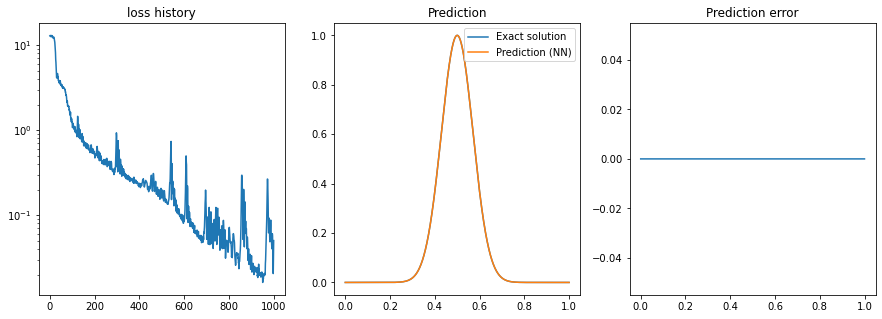

In [ ]:
network.plot(0.0)

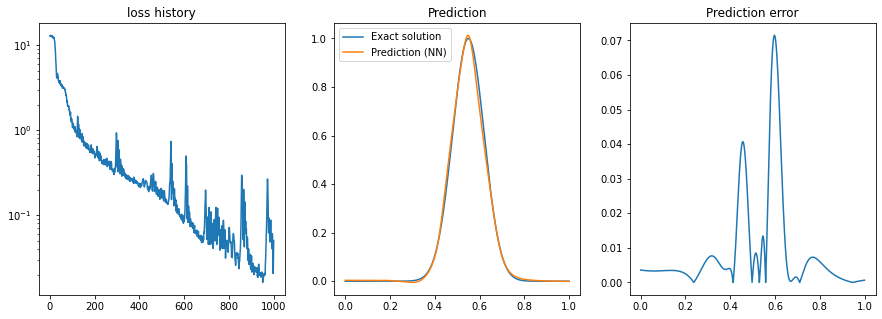

In [ ]:
network.plot(0.05)

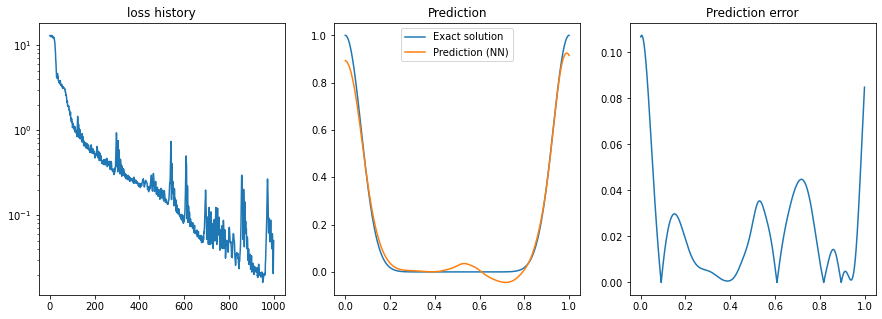

In [ ]:
network.plot(0.5)

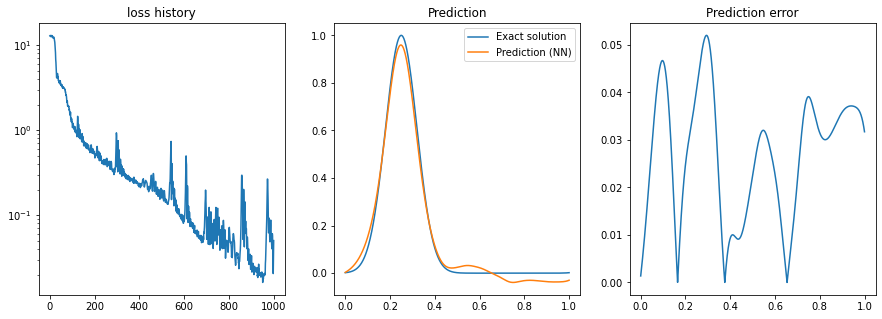

In [ ]:
network.plot(0.75)

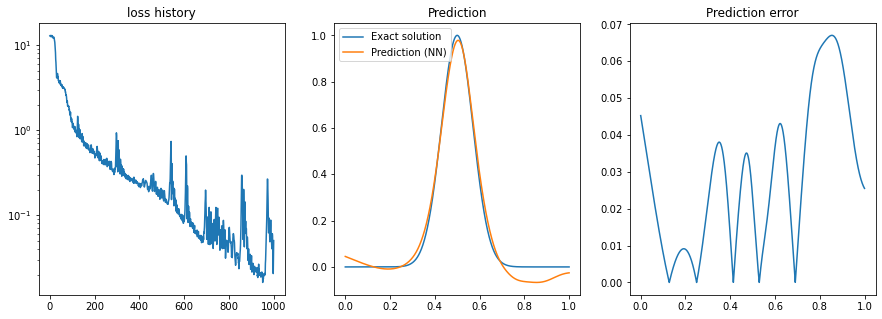

In [ ]:
network.plot(1.) 

If we add the parameter a for the hyperbolic tangent each neuron will have it's own activation function. that is equivalent to a second order problem without the hessian matrix (adaptive activate functions) more like adaptative training 